## Project 5: WAM News Prediction of  California's Gubernatorial 2021 Election

### Modeling - Neural Net

## Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# set random seed
import random
random.seed=42

## Load Data

In [2]:
tf.random.set_seed(
    1234
)

In [3]:
# read data
df=pd.read_csv('../data/2018_gov_clean.csv', index_col=0)
df.head()

,dist,ownhome,pid3,gender,age,educ,race,faminc,marstat,newsint,approval_gov,ideo5,voted_gov
392782,19,Other,Democrat,Female,54,4-Year,White,50k - 60k,Single / Never Married,Most of the time,Strongly Approve,Liberal,1
392786,52,Rent,Democrat,Female,28,Some College,White,20k - 30k,Single / Never Married,Most of the time,Strongly Approve,Liberal,1
392800,49,Own,Other,Male,86,Post-Grad,White,120k - 150k,Widowed,Most of the time,Strongly Disapprove,Very Conservative,0
392832,36,Own,Republican,Male,80,Some College,White,20k - 30k,Widowed,Most of the time,Strongly Disapprove,Conservative,0
392860,36,Own,Independent,Male,83,4-Year,White,Prefer not to say,Married,Most of the time,Strongly Disapprove,Conservative,0


In [4]:
# check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3663 entries, 392782 to 452724
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dist          3663 non-null   int64 
 1   ownhome       3663 non-null   object
 2   pid3          3663 non-null   object
 3   gender        3663 non-null   object
 4   age           3663 non-null   int64 
 5   educ          3663 non-null   object
 6   race          3663 non-null   object
 7   faminc        3663 non-null   object
 8   marstat       3663 non-null   object
 9   newsint       3663 non-null   object
 10  approval_gov  3663 non-null   object
 11  ideo5         3663 non-null   object
 12  voted_gov     3663 non-null   int64 
dtypes: int64(3), object(10)
memory usage: 400.6+ KB


In [5]:
# baseline accuracy
df.voted_gov.value_counts(normalize=True)

1    0.624352
0    0.375648
Name: voted_gov, dtype: float64

# Modeling

In [6]:
# set up X and y
X = df.drop(columns =['voted_gov'])
y = df['voted_gov']

In [7]:
# dummify X variable
X = pd.get_dummies(X, drop_first=True)

In [8]:
# checkout X shape
X.shape

(3663, 51)

In [9]:
# check if shape of X = y
assert X.shape[0]==y.shape[0]

### 1. Neural Net Classification - Early stopping

In [78]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [79]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [80]:
# create model with one hidden layer
model_nn1 = Sequential()
model_nn1.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn1.add(Dense(1, activation='sigmoid'))

In [81]:
# model summary
model_nn1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                1664      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 1,697
Trainable params: 1,697
Non-trainable params: 0
_________________________________________________________________


In [82]:
# Compile it
model_nn1.compile(loss='bce', optimizer='adam', metrics=['Accuracy', 'Recall'])

In [83]:
# set early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [84]:
# fit model
history = model_nn1.fit(
    X_train_sc, y_train, 
    validation_data=(X_test_sc, y_test), 
    epochs=100, 
    callbacks=[early_stop], 
    verbose=0,
    batch_size=32
)

Epoch 00015: early stopping


In [85]:
# save history into a df and checkout the last 5 epochs
history_df = pd.DataFrame(history.history)

In [94]:
history_df.tail()

,loss,Accuracy,recall,val_loss,val_Accuracy,val_recall
10,0.145074,0.943575,0.962682,0.196749,0.930131,0.956294
11,0.141404,0.945395,0.963848,0.197880,0.929039,0.958042
12,0.137701,0.945759,0.966764,0.198103,0.929039,0.952797
13,0.134162,0.947943,0.966764,0.199274,0.926856,0.951049
14,0.131740,0.946851,0.965015,0.199590,0.925764,0.949301


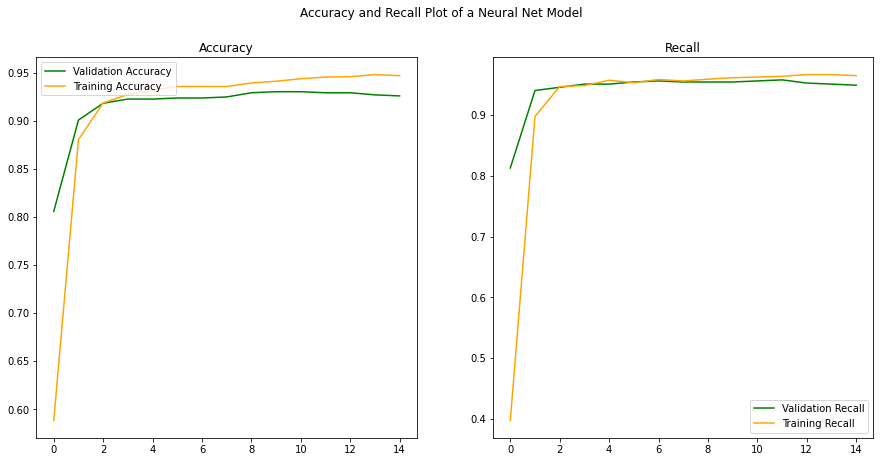

In [87]:
# subplots of accuracy, and recall
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (15, 7))
fig.suptitle('Accuracy and Recall Plot of a Neural Net Model')

# axis 1
ax1.plot(history_df['val_Accuracy'], label='Validation Accuracy', color='green')
ax1.plot(history_df['Accuracy'], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
ax1.title.set_text('Accuracy')

#axis3
ax2.plot(history_df['val_recall'], label='Validation Recall', color='green')
ax2.plot(history_df['recall'], label='Training Recall', color='orange')
ax2.legend(loc="upper left")
ax2.title.set_text('Recall')

plt.legend();

The plots show that this model with one hidden layer and early stopping is slightly overfit. 

In [88]:
# evaluate model
model_nn1.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.1996 - Accuracy: 0.9258 - recall: 0.9493


[0.19959016144275665, 0.9257642030715942, 0.9493007063865662]

In [89]:
# make predictions
y_pred_nn1=model_nn1.predict(X_test_sc)
y_pred_nn1[:10]

array([[0.83798224],
       [0.868325  ],
       [0.0025495 ],
       [0.9971823 ],
       [0.8383674 ],
       [0.98559064],
       [0.9985644 ],
       [0.99987674],
       [0.01134747],
       [0.99600875]], dtype=float32)

In [90]:
# round predicted values
y_pred_nn1 =y_pred_nn1.round()
y_pred_nn1[:10]

array([[1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [91]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn1
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[305,  39],
       [ 29, 543]], dtype=int32)>

In [92]:
# classification report
print(classification_report(y_test, y_pred_nn1))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       344
           1       0.93      0.95      0.94       572

    accuracy                           0.93       916
   macro avg       0.92      0.92      0.92       916
weighted avg       0.93      0.93      0.93       916



In [148]:
# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nn1).ravel()
# metrics
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)
spec= tn/(tn+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Specificity:', spec)

Accuracy: 0.925764192139738
Recall: 0.9493006993006993
Specificity: 0.8866279069767442


This model is slightly overfit with 92.5% accuracy on test and 0.95% accuracy on train.

### 2. Neural Net Classification - dropout

In [95]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [96]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [97]:
# instantiate model
model_nn2 = Sequential()

In [98]:
# create model
model_nn2.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(10, activation='relu'))
model_nn2.add(Dropout(0.2))
model_nn2.add(Dense(1, activation='sigmoid'))

In [99]:
# compile model
model_nn2.compile(loss='bce', optimizer ='adam', metrics = ['Accuracy', 'Recall'])

In [100]:
# fit model
history_2 = model_nn2.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_sc, y_test),
    epochs=100,
    verbose=0
)

In [101]:
# save history into a df
history_2_df = pd.DataFrame(history_2.history)

In [102]:
history_2_df.tail()

,loss,Accuracy,recall,val_loss,val_Accuracy,val_recall
95,0.074002,0.973790,0.983090,0.379315,0.911572,0.952797
96,0.065272,0.977430,0.989504,0.389331,0.914847,0.954545
97,0.068293,0.974518,0.987172,0.387689,0.918122,0.952797
98,0.066992,0.975610,0.987172,0.392319,0.918122,0.952797
99,0.083596,0.970149,0.983090,0.371817,0.915939,0.949301


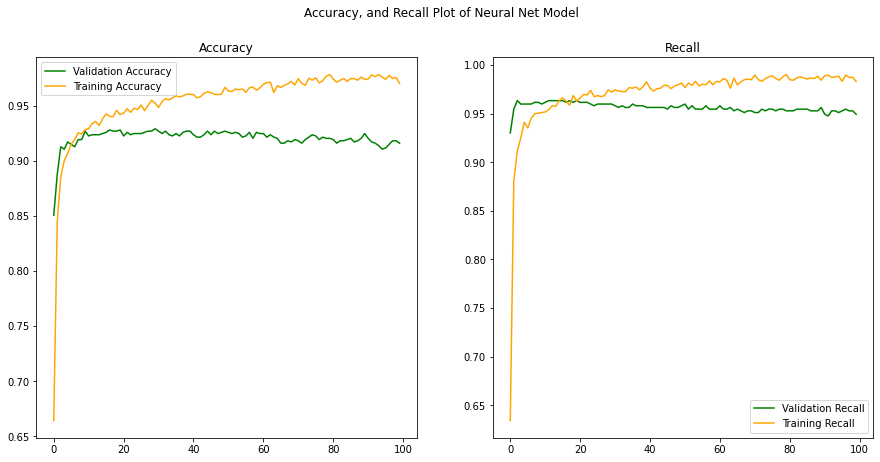

In [145]:
# subplots of accuracy, and recall
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (15, 7))
fig.suptitle('Accuracy, and Recall Plot of Neural Net Model')

# axis 1 - accuracy
ax1.plot(history_2_df["val_Accuracy"], label='Validation Accuracy', color='green')
ax1.plot(history_2_df["Accuracy"], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
ax1.title.set_text('Accuracy')
# axis2 - recall
ax2.plot(history_2_df['val_recall'], label='Validation Recall', color='green')
ax2.plot(history_2_df['recall'], label='Training Recall', color='orange')
ax2.legend(loc="upper right")
ax2.title.set_text('Recall')
plt.legend();

In [104]:
# evaluate model
model_nn2.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.3718 - Accuracy: 0.9159 - recall: 0.9493


[0.3718169629573822, 0.9159388542175293, 0.9493007063865662]

In [105]:
# make predictions
y_pred_nn2=model_nn2.predict(X_test_sc)
y_pred_nn2[:10]

array([[9.5945501e-01],
       [9.4353050e-01],
       [3.0948185e-13],
       [9.9920011e-01],
       [2.8730336e-01],
       [9.9872732e-01],
       [9.9999869e-01],
       [1.0000000e+00],
       [6.0598040e-08],
       [9.9999970e-01]], dtype=float32)

In [106]:
# round predicted values
y_pred_nn2 =y_pred_nn2.round()
y_pred_nn2[:10]

array([[1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [107]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn2
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[296,  48],
       [ 29, 543]], dtype=int32)>

In [108]:
# classification report
print(classification_report(y_test, y_pred_nn2))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       344
           1       0.92      0.95      0.93       572

    accuracy                           0.92       916
   macro avg       0.91      0.90      0.91       916
weighted avg       0.92      0.92      0.92       916



In [149]:
# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nn2).ravel()
# metrics
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)
spec= tn/(tn+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Specificity:', spec)

Accuracy: 0.915938864628821
Recall: 0.9493006993006993
Specificity: 0.8604651162790697


This model has a 97% accuracy on train and 92% accuracy on test; it is overfit.

### 3. Neural Net Classification - Early stopping & dropout

In [122]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [123]:
# scale data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [124]:
# instantiate model
model_nn3 = Sequential()

In [125]:
# create model
model_nn3.add(Dense(32, input_shape=(X_train_sc.shape[1],), activation='relu'))
model_nn3.add(Dropout(0.1))
model_nn3.add(Dense(32, activation='relu'))

model_nn3.add(Dense(1, activation='sigmoid'))

In [126]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [127]:
# compile model
model_nn3.compile(loss='bce', optimizer ='adam', metrics = ['Accuracy', 'Recall'])

In [128]:
# fit model
history_3 = model_nn3.fit(
    X_train_sc,
    y_train,
    validation_data=(X_test_sc, y_test),
    epochs=100,
    callbacks=early_stop,
    verbose=0
)

Epoch 00014: early stopping


In [129]:
# save history into a df
history_3_df = pd.DataFrame(history_3.history)

In [130]:
# checkout the last 5 epochs
history_3_df.tail()

,loss,Accuracy,recall,val_loss,val_Accuracy,val_recall
9,0.146139,0.940663,0.963265,0.211536,0.930131,0.952797
10,0.141099,0.943939,0.963265,0.217221,0.932314,0.959790
11,0.134579,0.940298,0.960350,0.219374,0.933406,0.965035
12,0.127534,0.949035,0.970262,0.220959,0.931223,0.956294
13,0.126370,0.951584,0.974927,0.224927,0.930131,0.956294


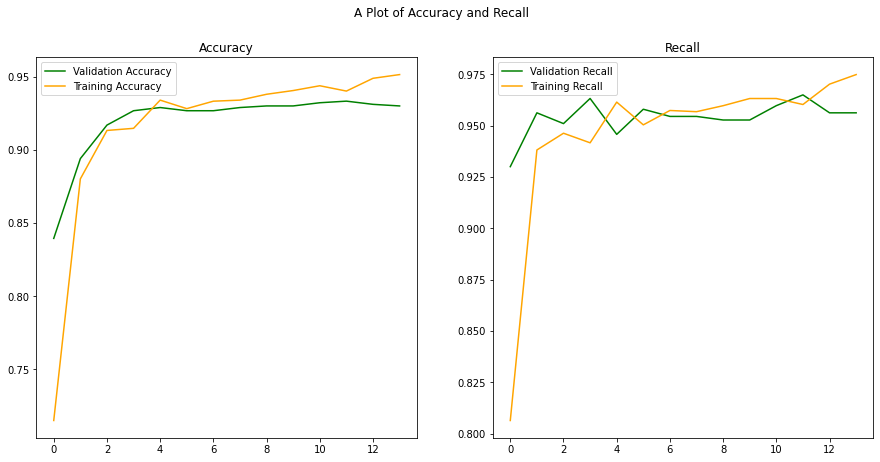

In [146]:
# subplots of accuracy, and recall
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols=2, figsize = (15, 7))
fig.suptitle('A Plot of Accuracy and Recall')

# axis 1 - accuracy
ax1.plot(history_3_df["val_Accuracy"], label='Validation Accuracy', color='green')
ax1.plot(history_3_df["Accuracy"], label='Training Accuracy', color='orange')
ax1.legend(loc="upper left")
ax1.title.set_text('Accuracy')
# axis2 - recall
ax2.plot(history_3_df['val_recall'], label='Validation Recall', color='green')
ax2.plot(history_3_df['recall'], label='Training Recall', color='orange')
ax2.legend(loc="upper left")
ax2.title.set_text('Recall')

plt.legend();

In [132]:
# evaluate model
model_nn3.evaluate(X_test_sc, y_test, verbose=2)

29/29 - 0s - loss: 0.2249 - Accuracy: 0.9301 - recall: 0.9563


[0.22492675483226776, 0.9301310181617737, 0.9562937021255493]

In [133]:
# make predictions
y_pred_nn3=model_nn3.predict(X_test_sc)
y_pred_nn3[:10]

array([[0.8294997 ],
       [0.8533538 ],
       [0.0020695 ],
       [0.9980995 ],
       [0.8369012 ],
       [0.9645968 ],
       [0.9996438 ],
       [0.999998  ],
       [0.00558698],
       [0.9982581 ]], dtype=float32)

In [134]:
# round predicted values
y_pred_nn3 =y_pred_nn3.round()
y_pred_nn3[:10]

array([[1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)

In [135]:
# confusion matrix using Tensorflow
tf.math.confusion_matrix(
    y_test, y_pred_nn3
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[305,  39],
       [ 25, 547]], dtype=int32)>

In [136]:
# classification report
print(classification_report(y_test, y_pred_nn3))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       344
           1       0.93      0.96      0.94       572

    accuracy                           0.93       916
   macro avg       0.93      0.92      0.92       916
weighted avg       0.93      0.93      0.93       916



In [147]:
# save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_nn3).ravel()
# metrics
accu = (tp+tn) / (tp+tn+fp+fn)
recall = tp/(tp+fn)
prec = tp/ (tp+fp)
spec= tn/(tn+fp)

print('Accuracy:', accu)
print('Recall:', recall)
print('Specificity:', spec)

Accuracy: 0.9301310043668122
Recall: 0.9562937062937062
Specificity: 0.8866279069767442


This model is slightly overfit with train accuracy of 95% and test accuracy of 93%. 

## Conclusion

- Neural Net models performed as well as Random forest interms of accuracy but they are overfit. 
- Our best model is a random forest model with accuracy of 93% both on train and test data. The most important metrics we looked at to pick our model is accuracy. For models with the same accuracy, we also looked at recall and specificity. 
- Our goal is to make accurate predictions of voter preferences for 2021 gubernatorial election in California. We also optimized for least number of misclassifications of both classes, republican and democrat. 